In [1]:
from __future__ import division

import pandas as pd
import re
import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import mean_absolute_error as score_MAE
from sklearn.metrics import mean_squared_error as score_MSE 
from sklearn.metrics import median_absolute_error as score_MED
from sklearn.metrics import r2_score as score_R2
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import *
import scipy.stats as stats
from datetime import datetime
import os.path

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,RepeatedKFold,LeaveOneOut


%matplotlib inline



def load_data(metadata,datafile):

    meta = pd.read_csv(metadata)
    
    dfo = pd.read_csv(datafile, header=None)
    df = dfo.iloc[:,8:].T
    pdat = df.iloc[:,0].asobject

    uid = []
    ageType = []
    age = []
    source = []
    condition = []
    ethnicity = []
    gender = []
    
    for el in pdat:
        tid = el.split('_')[0]
        mdata = meta[meta['Tracking ID']==tid]
        uid.append(el)  
    
        x = mdata['Age'].iloc[0].lower()
        if 'fw' in x:
            ageType.append('fw') 
            m = re.search('\d{1,2} ?fw',x)
            age.append(int(m.group(0)[:-2]))
        elif 'nb' in x:
            ageType.append('nb')
            age.append(0)
        elif 'da' in x:
            ageType.append('nb')
            age.append(0)
        elif 'yr' in x:
            ageType.append('yr')
            m = re.search('\d{1,3} ?yr',x)
            # maybe use months sometime too, but not now
            # m2 = re.search('\d{1,2} ?mo',x) 
            age.append(int(m.group(0)[:-2]))
        else:
            print("OOOPS! " + x)
                

        x = mdata['Condition'].iloc[0].lower()      
#        could be any of these types:
#                lab derived fibroblasts
#                normal
#                direct skin biopsy
#                control for hgps
#                relative of hgps
#                control for ism
#                ism
#                ism(sorted)
#                ism(hgps)
#                ism(relative of hgps)
#                heated direct skin biopsy
        condition.append(x)
        if 'fibroblast' in x:
            source.append('fibroblast')
        elif 'biopsy' in x:
            source.append('biopsy')
        else:
            source.append('coriell')
            
        gender.append( mdata['Gender'].iloc[0].lower() )
        ethnicity.append( mdata['Race/Ethnicity'].iloc[0].lower() )
   
            
            
    #
    #df = df.drop(0)
    #del df['patient data']
    #print len(ageType),len(age), len(condition), len(source), len(df)
    
    
    df.index = uid
    df.drop(df.columns[0],axis=1,inplace=True)
    df.columns = dfo.iloc[1:,0]
    trnum=[]
    for el in df.index:
        xx = el.split('_')[0]
        if xx=='pdl33': # get rid of the non-numeric tracking number which indicates #147 cells cultured to population doubling level 33
            trnum.append(33147)
        else:
            trnum.append(int(xx))
    df['tracking number'] = trnum
    df['ethnicity'] = ethnicity
    df['gender'] = gender
    df['source'] = source
    df['condition'] = condition
    df['age type'] = ageType
    df['age'] = age
    
    # rearrange so its easy to make a data matrix
    cols = df.columns.tolist()
    ncols = cols[-7:] + cols[:-7]
    df = df[ncols]   

    
    return df




alldata = load_data('MetaDataSheet.csv','fpkm.csv')


normals = (alldata.condition == 'normal') 
progeria = (alldata.condition == 'hgps')  
genes = alldata.iloc[:,7:].astype(float) # get only the gene expression levels, exclude the metadata
ages = alldata[normals].age 
age_prog = alldata[progeria].age


/home/guillermo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/guillermo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: 'asobject' is deprecated. Use 'astype(object)' instead


In [11]:
alldata[normals]

0                                   tracking number          ethnicity  \
101_19yr_Female_Caucasian/ FPKM                 101          caucasian   
102_19yr_Male_Caucasian/ FPKM                   102          caucasian   
103_19yr_Male_Caucasian/ FPKM                   103          caucasian   
104_19yr_Male_Caucasian/ FPKM                   104          caucasian   
105_20yr_Male_Caucasian/ FPKM                   105          caucasian   
...                                             ...                ...   
94_12_male_Caucasian/ FPKM                       94          caucasian   
95_13yr_Male_WhiTEEASTINDIAN/ FPKM               95  white/east indian   
97_16yr_Female_Unknown/ FPKM                     97            unknown   
98_17yr_Male_Caucasian/ FPKM                     98          caucasian   
99_17yr_Male_Caucasian/ FPKM                     99          caucasian   

0                                   gender   source condition age type  age  \
101_19yr_Female_Caucasian/ FPKM     female  coriell    normal       yr   19   
102_19yr_Male_Caucasian/ FPKM         male  coriell    normal       yr   19   
103_19yr_Male_Caucasian/ FPKM         male  coriell    normal       yr   19   
104_19yr_Male_Caucasian/ FPKM         male  coriell    normal       yr   19   
105_20yr_Male_Caucasian/ FPKM         male  coriell    normal       yr   20   
...                                    ...      ...       ...      ...  ...   
94_12_male_Caucasian/ FPKM            male  coriell    normal       yr   12   
95_13yr_Male_WhiTEEASTINDIAN/ FPKM    male  coriell    normal       yr   13   
97_16yr_Female_Unknown/ FPKM        female  coriell    normal       yr   16   
98_17yr_Male_Caucasian/ FPKM          male  coriell    normal       yr   17   
99_17yr_Male_Caucasian/ FPKM          male  coriell    normal       yr   17   

0                                  NM_173803 NM_014423 NM_001103167  ...  \
101_19yr_Female_Caucasian/ FPKM        0.133     16.98        0.387  ...   
102_19yr_Male_Caucasian/ FPKM          0.213    16.772        0.168  ...   
103_19yr_Male_Caucasian/ FPKM          0.054    16.206         0.41  ...   
104_19yr_Male_Caucasian/ FPKM          0.066    15.345        0.148  ...   
105_20yr_Male_Caucasian/ FPKM          0.156    16.873        0.252  ...   
...                                      ...       ...          ...  ...   
94_12_male_Caucasian/ FPKM             0.214    16.103        0.323  ...   
95_13yr_Male_WhiTEEASTINDIAN/ FPKM     0.041    15.899        0.486  ...   
97_16yr_Female_Unknown/ FPKM           0.204     16.79        0.385  ...   
98_17yr_Male_Caucasian/ FPKM           0.177     9.796        0.452  ...   
99_17yr_Male_Caucasian/ FPKM               0     14.04         0.55  ...   

0                                  NR_029666 NM_080390 NM_001177675 NR_125786  \
101_19yr_Female_Caucasian/ FPKM            0         0            0         0   
102_19yr_Male_Caucasian/ FPKM              0         0            0         0   
103_19yr_Male_Caucasian/ FPKM              0     0.037            0         0   
104_19yr_Male_Caucasian/ FPKM              0         0        0.022         0   
105_20yr_Male_Caucasian/ FPKM              0     0.091            0         0   
...                                      ...       ...          ...       ...   
94_12_male_Caucasian/ FPKM                 0     0.049            0         0   
95_13yr_Male_WhiTEEASTINDIAN/ FPKM         0     0.042            0         0   
97_16yr_Female_Unknown/ FPKM               0     0.046            0         0   
98_17yr_Male_Caucasian/ FPKM               0     0.949            0         0   
99_17yr_Male_Caucasian/ FPKM               0      0.18            0         0   

0                                  NM_001291993 NM_021923 NM_017417 NM_004354  \
101_19yr_Female_Caucasian/ FPKM           4.349    29.242      0.04     6.139   
102_19yr_Male_Caucasian/ FPKM             5.642    31.561         0     5.603   
103_19yr_Male_Caucasian/ FPKM    

In [5]:
genes[normals]

0                                   NM_173803  NM_014423  NM_001103167  \
101_19yr_Female_Caucasian/ FPKM         0.133     16.980         0.387   
102_19yr_Male_Caucasian/ FPKM           0.213     16.772         0.168   
103_19yr_Male_Caucasian/ FPKM           0.054     16.206         0.410   
104_19yr_Male_Caucasian/ FPKM           0.066     15.345         0.148   
105_20yr_Male_Caucasian/ FPKM           0.156     16.873         0.252   
...                                       ...        ...           ...   
94_12_male_Caucasian/ FPKM              0.214     16.103         0.323   
95_13yr_Male_WhiTEEASTINDIAN/ FPKM      0.041     15.899         0.486   
97_16yr_Female_Unknown/ FPKM            0.204     16.790         0.385   
98_17yr_Male_Caucasian/ FPKM            0.177      9.796         0.452   
99_17yr_Male_Caucasian/ FPKM            0.000     14.040         0.550   

0                                   NR_134623  NR_024490  NM_018397  \
101_19yr_Female_Caucasian/ FPKM          0.00      0.626      0.115   
102_19yr_Male_Caucasian/ FPKM            0.00      0.701      0.077   
103_19yr_Male_Caucasian/ FPKM            0.00      1.135      0.284   
104_19yr_Male_Caucasian/ FPKM            0.00      0.685      0.304   
105_20yr_Male_Caucasian/ FPKM            0.09      0.806      0.094   
...                                       ...        ...        ...   
94_12_male_Caucasian/ FPKM               0.00      1.042      0.086   
95_13yr_Male_WhiTEEASTINDIAN/ FPKM       0.00      1.492      0.087   
97_16yr_Female_Unknown/ FPKM             0.00      1.006      0.014   
98_17yr_Male_Caucasian/ FPKM             0.00      0.743      0.147   
99_17yr_Male_Caucasian/ FPKM             0.00      0.883      0.214   

0                                   NM_001037671  NR_106859  NM_133458  \
101_19yr_Female_Caucasian/ FPKM              0.0     31.531      5.500   
102_19yr_Male_Caucasian/ FPKM                0.0     27.992      6.473   
103_19yr_Male_Caucasian/ FPKM                0.0     25.915      6.770   
104_19yr_Male_Caucasian/ FPKM                0.0     18.776      5.773   
105_20yr_Male_Caucasian/ FPKM                0.0     18.481      5.052   
...                                          ...        ...        ...   
94_12_male_Caucasian/ FPKM                   0.0     27.271      4.877   
95_13yr_Male_WhiTEEASTINDIAN/ FPKM           0.0     31.619      5.026   
97_16yr_Female_Unknown/ FPKM                 0.0     20.793      4.287   
98_17yr_Male_Caucasian/ FPKM                 0.0     43.818      4.447   
99_17yr_Male_Caucasian/ FPKM                 0.0     24.032      5.429   

0                                   NM_001080424  ...  NR_029666  NM_080390  \
101_19yr_Female_Caucasian/ FPKM            1.308  ...        0.0      0.000   
102_19yr_Male_Caucasian/ FPKM              1.357  ...        0.0      0.000   
103_19yr_Male_Caucasian/ FPKM              1.495  ...        0.0      0.037   
104_19yr_Male_Caucasian/ FPKM              1.688  ...        0.0      0.000   
105_20yr_Male_Caucasian/ FPKM              1.384  ...        0.0      0.091   
...                                          ...  ...        ...        ...   
94_12_male_Caucasian/ FPKM                 1.369  ...        0.0      0.049   
95_13yr_Male_WhiTEEASTINDIAN/ FPKM         1.080  ...        0.0      0.042   
97_16yr_Female_Unknown/ FPKM               1.404  ...        0.0      0.046   
98_17yr_Male_Caucasian/ FPKM               1.735  ...        0.0      0.949   
99_17yr_Male_Caucasian/ FPKM               1.270  ...        0.0      0.180   

0                                   NM_001177675  NR_125786  NM_001291993  \
101_19yr_Female_Caucasian/ FPKM            0.000        0.0         4.349   
102_19yr_Male_Caucasian/ FPKM              0.000        0.0         5.642   
103_19yr_Male_Caucasian/ FPKM              0.000        0.0         6.132   
104_19yr_Male_Caucasian/ FPKM              0.022        0.0         3.752   
105_20yr_Male_Caucasian/ FPKM      

In [5]:

class subset_genes_LinRegr(LinearRegression):
    
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                     n_jobs=1, subset_min=0, subset_fold=0, subset_logT=False, convfpkmToTpm=False, verbose=False):
            self.subset_min = subset_min
            self.subset_fold = subset_fold
            self.subset_logT = subset_logT
            self.convfpkmToTpm = convfpkmToTpm
            self.verbose = verbose

            super(subset_genes_LinRegr, self).__init__(
                    fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs )
        
        
    def _expr_levels(self, data,logTrans=False):
        if logTrans:
            return np.log2(data + 1)
        else:
            return data
        
    # this version of subset genes assumes data is ONLY genes with no metadata columns in a pd.DataFrame 
    def _subset_genes(self, data, verbose=False, these_genes=np.array(False) ):
        if these_genes.any(): # just get these_genes
            genes = self._expr_levels(data,logTrans=self.subset_logT)      
        else: # calculate the these_genes list based on the other parameters    
            
            genes = self._expr_levels(data,logTrans=False)  # operate selection criteria on non-log FPKM
            eps = 0.001
            has_start_gt = genes > self.subset_min
            mvt = genes.min()
            mvt[ mvt<eps ] = eps
            has_fold_change = (genes.max() / mvt)  > self.subset_fold
            
            aset = (has_start_gt.any(axis=0) & has_fold_change)
            these_genes = aset[ aset ].index # get list of gene names that meet criteria
            genes = self._expr_levels(data,logTrans=self.subset_logT) # do the final op on user-selected xform
            
        subgenes = genes.loc[:,these_genes]        
        if verbose:
            print 'using {} genes in subset requiring a max FPKM > {} and > {}fold change between max and min samples '.format(len(these_genes), self.subset_min, self.subset_fold)

        return subgenes

        

    def predict(self, X):
        """Perform regression on samples in X.
        For an one-class model, +1 (inlier) or -1 (outlier) is returned.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            For kernel="precomputed", the expected shape of X is
            (n_samples_test, n_samples_train).
        Returns
        -------
        y_pred : array, shape (n_samples,)
        """
        check_is_fitted(self, 'genecolumns_')
        X_sub = self._subset_genes(X, these_genes=self.genecolumns_)
        #X_sub = super(subset_genes_LinRegr, self)._validate_for_predict(X_sub)
        return super(subset_genes_LinRegr, self).predict(X_sub)
    
    def fit(self, X, y, sample_weight=None):
        check_is_fitted(self, 'subset_min')
        check_is_fitted(self, 'subset_fold')
        check_is_fitted(self, 'subset_logT')
        X_sub = self._subset_genes(X, verbose=self.verbose)
        self.genecolumns_ = X_sub.columns
        super(subset_genes_LinRegr, self).fit(X_sub, y, sample_weight)
        return self
        

SyntaxError: invalid syntax (<ipython-input-5-eea0a1e8b22c>, line 40)

In [14]:

class subset_genes_ElasticNet(ElasticNet):
    
    def __init__(self, alpha=1.0, l1_ratio=0.5, fit_intercept=True,
                 normalize=False, precompute=False, max_iter=1000,
                 copy_X=True, tol=1e-4, warm_start=False, positive=False,
                 random_state=None, selection='cyclic', 
                 subset_min=0, subset_fold=0, subset_logT=False, convfpkmToTpm=False, verbose=False):
            self.subset_min = subset_min
            self.subset_fold = subset_fold
            self.subset_logT = subset_logT
            self.convfpkmToTpm = convfpkmToTpm
            self.verbose = verbose

            super(subset_genes_ElasticNet, self).__init__(
                 alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept,
                 normalize=normalize, precompute=precompute, max_iter=max_iter,
                 copy_X=copy_X, tol=tol, warm_start=warm_start, positive=positive,
                 random_state=random_state, selection=selection )
            
    def _expr_levels(self, data,logTrans=False):
        if logTrans:
            return np.log2(data + 1)
        else:
            return data
        
    # this version of subset genes assumes data is ONLY genes with no metadata columns in a pd.DataFrame 
    def _subset_genes(self, data, verbose=False, these_genes=np.array(False) ):
        if these_genes.any(): # just get these_genes
            genes = self._expr_levels(data,logTrans=self.subset_logT)      
        else: # calculate the these_genes list based on the other parameters    
            
            genes = self._expr_levels(data,logTrans=False)  # operate selection criteria on non-log FPKM
            eps = 0.001
            has_start_gt = genes > self.subset_min
            mvt = genes.min()
            mvt[ mvt<eps ] = eps
            has_fold_change = (genes.max() / mvt)  > self.subset_fold
            
            aset = (has_start_gt.any(axis=0) & has_fold_change)
            these_genes = aset[ aset ].index # get list of gene names that meet criteria
            genes = self._expr_levels(data,logTrans=self.subset_logT) # do the final op on user-selected xform
            
        subgenes = genes.loc[:,these_genes]        
        if verbose:
            print 'using {} genes in subset requiring a max FPKM > {} and > {}fold change between max and min samples '.format(len(these_genes), self.subset_min, self.subset_fold)

        return subgenes

        

    def predict(self, X):
        """Perform regression on samples in X.
        For an one-class model, +1 (inlier) or -1 (outlier) is returned.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            For kernel="precomputed", the expected shape of X is
            (n_samples_test, n_samples_train).
        Returns
        -------
        y_pred : array, shape (n_samples,)
        """
        check_is_fitted(self, 'genecolumns_')
        X_sub = self._subset_genes(X, these_genes=self.genecolumns_)
        #X_sub = super(subset_genes_LinRegr, self)._validate_for_predict(X_sub)
        return super(subset_genes_ElasticNet, self).predict(X_sub)
    
    def fit(self, X, y, check_input=True):
        check_is_fitted(self, 'subset_min')
        check_is_fitted(self, 'subset_fold')
        check_is_fitted(self, 'subset_logT')
        check_is_fitted(self, 'convfpkmToTpm')
        X_sub = self._subset_genes(X, verbose=self.verbose)
        self.genecolumns_ = X_sub.columns
        super(subset_genes_ElasticNet, self).fit(X_sub, y, check_input)
        return self
        

In [15]:

class subset_genes_SVR(SVR):
    
    def __init__(self, kernel='rbf', degree=3, gamma='auto', coef0=0.0,
                 tol=1e-3, C=1.0, epsilon=0.1, shrinking=True,
                 cache_size=200, verbose=False, max_iter=-1,
                 subset_min=0, subset_fold=0, subset_logT=False):
        self.subset_min = subset_min
        self.subset_fold = subset_fold
        self.subset_logT = subset_logT

        super(subset_genes_SVR, self).__init__(
            kernel=kernel, degree=degree, gamma=gamma,
            coef0=coef0, tol=tol, C=C, epsilon=epsilon, verbose=verbose,
            shrinking=shrinking, cache_size=cache_size, max_iter=max_iter)
        
        
    def _expr_levels(self, data,logTrans=False):
        if logTrans:
            return np.log2(data + 1)
        else:
            return data
        
    # this version of subset genes assumes data is ONLY genes with no metadata columns in a pd.DataFrame 
    def _subset_genes(self, data, verbose=False, these_genes=np.array(False) ):
        if these_genes.any(): # just get these_genes
            genes = self._expr_levels(data,logTrans=self.subset_logT)      
        else: # calculate the these_genes list based on the other parameters    
            
            genes = self._expr_levels(data,logTrans=False)  # operate selection criteria on non-log FPKM
            eps = 0.001
            has_start_gt = genes > self.subset_min
            mvt = genes.min()
            mvt[ mvt<eps ] = eps
            has_fold_change = (genes.max() / mvt)  > self.subset_fold
            
            aset = (has_start_gt.any(axis=0) & has_fold_change)
            these_genes = aset[ aset ].index # get list of gene names that meet criteria
            genes = self._expr_levels(data,logTrans=self.subset_logT) # do the final op on user-selected xform
            
        subgenes = genes.loc[:,these_genes]        
        if verbose:
            print 'using {} genes in subset requiring a max FPKM > {} and > {}fold change between max and min samples '.format(len(these_genes), self.subset_min, self.subset_fold)

        return subgenes
        

    def predict(self, X):
        """Perform regression on samples in X.
        For an one-class model, +1 (inlier) or -1 (outlier) is returned.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            For kernel="precomputed", the expected shape of X is
            (n_samples_test, n_samples_train).
        Returns
        -------
        y_pred : array, shape (n_samples,)
        """
        check_is_fitted(self, 'genecolumns_')
        X_sub = self._subset_genes(X, these_genes=self.genecolumns_)
        X_sub = super(subset_genes_SVR, self)._validate_for_predict(X_sub)
        predict = self._sparse_predict if self._sparse else self._dense_predict
        return predict(X_sub)
    
    def fit(self, X, y, sample_weight=None):
        check_is_fitted(self, 'subset_min')
        check_is_fitted(self, 'subset_fold')
        check_is_fitted(self, 'subset_logT')
        X_sub = self._subset_genes(X, verbose=self.verbose)
        self.genecolumns_ = X_sub.columns
        super(subset_genes_SVR, self).fit(X_sub, y, sample_weight)
        return self
        

In [68]:

class subset_genes_ensemble(BaseEstimator, ClassifierMixin):
    
    def __init__(self, clf=None, class_size=20, subset_min=0, subset_fold=0, subset_logT=False, verbose=False):
            self.subset_min = subset_min
            self.subset_fold = subset_fold
            self.subset_logT = subset_logT
            self.clf = clf
            self.class_size = class_size
            self.verbose = verbose

            
        
    def _expr_levels(self, data,logTrans=False):
        if logTrans:
            return np.log2(data + 1)
        else:
            return data
        
    # this version of subset genes assumes data is ONLY genes with no metadata columns in a pd.DataFrame 
    def _subset_genes(self, data, verbose=False, these_genes=np.array(False) ):
        if these_genes.any(): # just get these_genes
            genes = self._expr_levels(data,logTrans=self.subset_logT)      
        else: # calculate the these_genes list based on the other parameters    
            
            genes = self._expr_levels(data,logTrans=False)  # operate selection criteria on non-log FPKM
            eps = 0.001
            has_start_gt = genes > self.subset_min
            mvt = genes.min()
            mvt[ mvt<eps ] = eps
            has_fold_change = (genes.max() / mvt)  > self.subset_fold
            
            aset = (has_start_gt.any(axis=0) & has_fold_change)
            these_genes = aset[ aset ].index # get list of gene names that meet criteria
            genes = self._expr_levels(data,logTrans=self.subset_logT) # do the final op on user-selected xform
            
        subgenes = genes.loc[:,these_genes]        
        if verbose:
            print 'using {} genes in subset requiring a max FPKM > {} and > {}fold change between max and min samples '.format(len(these_genes), self.subset_min, self.subset_fold)

        return subgenes
    
    def _get_bounds(self, minimum,maximum,offset,interval):

        done = False;
        lower = minimum;
        while (not done):
            if (lower==minimum):
                if (offset>0):
                    upper = lower+offset;
                else:
                    upper = lower+interval;

                bounds = np.array([[lower,upper-1]]);
                lower = upper;
                continue;
            else:
                upper = min(lower+interval,maximum+1);

            done = upper>maximum;
            bounds = np.append(bounds,[[lower,upper-1]],axis=0);

            lower = upper;
        return bounds;
    
    def _predict_age(self, train_feat, train_age, test_feat, class_size, clf):
        n_samp = len(train_age);
        age_min = min(train_age);
        age_max = max(train_age);

        votes = []
        for _ in range(test_feat.shape[0]): # make a votes list of lists as long as the number of test samples
            votes.append([])

        # For each partition
        for offset in range(0,class_size):    
            bounds = self._get_bounds(age_min,age_max,offset,class_size);
            n_classes = len(bounds);
            train_class = np.empty(n_samp,dtype=object);
            class_names = np.empty(n_classes,dtype=object)

            for i in range(0,n_classes):
                lower = bounds[i][0];
                upper = bounds[i][1];
                class_names[i] = str(lower) + '-' + str(upper);
                in_class = np.logical_and(train_age>=lower,train_age<=upper);
                train_class[in_class] = class_names[i];

            # Train
            clf.fit(train_feat,train_class);
            self.classifiers_.append(clf)

            # Predict an age class for the current sample
            predictions = clf.predict(test_feat);

            """        
            Each vote for age i is stored as an single instance of integer i 
            (i.e. by analogy, a slip with the age is placed in a ballot box) 
            so that the mean and median predicted age can be taken in addition to 
            or instead of the mode.
            """
            for k, class_predict in enumerate(predictions):
                
                # Generate constituent integer ages from the predicted age class
                bnd_predict = bounds[class_names == class_predict][0];
                this_vote = np.arange(bnd_predict[0],bnd_predict[1]+1,1);

                # Store predicted integer ages
                votes[k] = np.append(votes[k],this_vote);

        # Take the mode (or median or mean or some more elaborate voting scheme if you like) integer predicted age
        # as the final predicted age
        age_predict = [ stats.mode(vs).mode[0] for vs in votes]

        return (age_predict, votes)

    
    def predict(self, X):
        check_is_fitted(self, 'genecolumns_')
        check_is_fitted(self, 'train_data_')
        check_is_fitted(self, 'train_label_')
        X_sub = self._subset_genes(X, these_genes=self.genecolumns_)
        pred, votes =  self._predict_age(self.train_data_, self.train_label_, X_sub, self.class_size, self.clf)
        self.votes_ = votes
        return pred
    
    def fit(self, X, y):
        check_is_fitted(self, 'subset_min')
        check_is_fitted(self, 'subset_fold')
        check_is_fitted(self, 'subset_logT')
        X_sub = self._subset_genes(X, verbose=True)
        self.genecolumns_ = X_sub.columns
        self.train_data_ = X_sub
        self.train_label_ = y
        self.classifiers_ = []
        # do nothing except store variables... predict_age does both fit_ & predict
        return self
    



In [54]:
def estimate_accuracy_gained_persample(clf, gene_data, age_labels, metric, crossval, n_jobs):
     
    lc_sizes = [60, 75, 90, 105, 119] # 119 not 120 because small variations in fold generation can cause us to run out of samples at 120
    scorer = sklearn.metrics.make_scorer(metric)
    tsizes, train_score, test_score = sklearn.model_selection.learning_curve(
            clf, gene_data, age_labels, train_sizes=lc_sizes, cv = crossval, 
            scoring=scorer, n_jobs = njobs, pre_dispatch = 2*njobs, shuffle=False, verbose=2)
    size_labels = np.repeat(tsizes,test_score.shape[1])
    learning_curve = pd.DataFrame( { 
        'Test set {}'.format(scorer._score_func.func_name):
            np.reshape(test_score,[np.prod(test_score.shape),]),
        'Training set {}'.format(scorer._score_func.func_name):
            np.reshape(train_score,[np.prod(train_score.shape),]),
        'Training set size':size_labels} )
    #sns.lmplot(data=learning_curve, x='Training set size',
    #       y='Test set {}'.format(scorer._score_func.func_name))
    return learning_curve





In [270]:
def make_figs( name,  model=False, search_cval=False, parameters=None, plot_cval=False, lcurve_cval=False, njobs=1):

    # makes use of global variables: normals, progeria, genes, ages, etc...
    
    if search_cval:
        print "grid searching..."
        clfcv = GridSearchCV(model, parameters, cv=search_cval, n_jobs=njobs, pre_dispatch=2*njobs, scoring='neg_mean_absolute_error', verbose=2)
        clfcv.fit( genes[normals], ages)
        clf = clfcv.best_estimator_
        dump(clfcv.cv_results_,'fig2_searchresults_{}.pkl'.format(name))
        dump(clf,'fig2_bestmodel_{}.pkl'.format(name))
    else: #
        if model: # no search, just use model in the case of parameterless algortihms like linear regression
            clf = model
        else: # load up a previously saved model
            clf = load('fig2_bestmodel_{}.pkl'.format(name))
    
    print "Using ",clf
        
    if plot_cval:
        print "LOOCV...", clf
        true_age = []
        pred_age = []
        for train, test in plot_cval.split(genes[normals]):
            clf.fit(genes[normals].iloc[train,:],ages[train])
            pred_age.append( clf.predict(genes[normals].iloc[test,:]) )
            true_age.append( ages[test] )
        pred_age = np.array(pred_age).flatten() 
        true_age = np.array(true_age).flatten()
        
        clf.fit(genes[normals],ages)
        prog_predict = clf.predict(genes[progeria])
        np.save('fig2_pred_age_{}.npy'.format(name),pred_age)
        np.save('fig2_true_age_{}.npy'.format(name),true_age)
        np.save('fig2_pred_prog_age_{}.npy'.format(name),prog_predict)
        dump(clf,'fig2_modelafterloocv_{}.pkl'.format(name))
        # don't need to save true progeria age because there's no way for it to be order permuted by a cross-validator
    else:
        pred_age = np.load('fig2_pred_age_{}.npy'.format(name))
        true_age = np.load('fig2_true_age_{}.npy'.format(name))
        prog_predict = np.load('fig2_pred_prog_age_{}.npy'.format(name))
        #clf = load('fig2_modelafterloocv_{}.pkl'.format(name))

              
    if lcurve_cval:
        print "learning curve..."
        lcurve = estimate_accuracy_gained_persample(clf, genes[normals], ages, score_MAE, lcurve_cval, njobs)
        lcurve['Mean absolute error'] = lcurve['Test set mean_absolute_error']
        lcurve.to_csv('lcurve_{}.csv'.format(name))
    else:
        lcurve = pd.read_csv('lcurve_{}.csv'.format(name))
              

    #errstr = "{} MAE:{:3.2f} MED:{:3.2f} R2:{:3.2f}".format( name, score_MAE(true_age,pred_age), score_MED(true_age,pred_age), score_R2(true_age,pred_age))
    errstr = "MAE:{:3.1f} MED:{:3.1f} R2:{:3.2f}".format( score_MAE(true_age,pred_age), score_MED(true_age,pred_age), score_R2(true_age,pred_age)) 

    sns.set_style('white')
    sns.set_palette( sns.xkcd_palette(['nice blue','faded red']))
    
    fig1 = plt.figure(figsize=(3.5,3.5));
    ax1 = fig1.add_subplot(111);
    sns.regplot(true_age,pred_age, ax=ax1)
    ax1.plot([0,100],[0,100],'k:')
    ax1.text(0.99, 0.03, errstr,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax1.transAxes)
    #plt.title(name)
    plt.axis('equal')
    ax1.set_xlabel('True age (years)'), ax1.set_ylabel('Predicted age (years)');
    sns.despine()
    plt.tight_layout()
    plt.draw()
    plt.savefig('fig2_plot_predictions_{}.png'.format(name),dpi=400)
    print "LOOCV ", name, errstr

    fig2 = plt.figure(figsize=(3.5,3.5));
    ax2 = fig2.add_subplot(111);
    # we had to use 119 to avoid a kfold issue, but aesthestically I want it to show 120 so the progression of set size is even
    lcurve.loc[ lcurve['Training set size']==119, 'Training set size' ] = 120
    sns.regplot(data=lcurve, x='Training set size', y='Mean absolute error', ax=ax2)
    #sns.boxplot(data=lcurve, x='Training set size', y='Mean absolute error', color='white', ax=ax2)
    #plt.title(name)
    plt.ylim([0,30])
    #plt.xlim([50,130])
    sns.despine()
    plt.tight_layout()
    plt.draw()
    plt.savefig('fig2_plot_learning_curve_{}.png'.format(name),dpi=400)
    
    fig3 = plt.figure(figsize=(3.5,3.5));
    ax3 = fig3.add_subplot(111);
    these = (true_age < 10)
    sns.regplot(true_age[these],pred_age[these],ax=ax3,label='Controls',fit_reg=False)#,color='xkcd:nice blue')
    sns.regplot(age_prog,np.array(prog_predict),ax=ax3,label='Progeria',fit_reg=False)#,color='xkcd:faded red')
    #plt.title(name)
    ax3.plot([0,10],[0,10],'k:')
    plt.ylim([-15,40])
    plt.xlabel('True age (years)')
    plt.ylabel('Predicted age (years)')
    leg=plt.legend(frameon=True)
    leg.get_frame().set_facecolor('xkcd:light gray')
    plt.tight_layout()
    sns.despine()
    plt.draw()
    plt.savefig('fig2_plot_progeria{}.png'.format(name),dpi=400)
    
    fig4 = plt.figure(figsize=(3.5,3.5));
    ax4 = fig4.add_subplot(111);
    these = (true_age < 10)
    toplot = pd.DataFrame({'True age (years)':np.hstack([true_age[these],age_prog]), 
                           'Predicted age (years)':np.hstack([pred_age[these],prog_predict]),
                           'Sample':np.hstack([['Controls' for el in true_age[these]], ['Progeria' for el in age_prog]])
                          })
    sns.boxplot(data=toplot, y='Predicted age (years)', x='Sample', ax=ax4)
    v1 = toplot.loc[toplot.Sample=='Progeria','Predicted age (years)']
    v2 = toplot.loc[toplot.Sample=='Controls','Predicted age (years)']
    ts, pv = stats.ttest_ind(v1,v2)
    pstr = 'Diff of means: {:.2e}\nStudent\'s t={:.2e}, p={:.2e}'.format( v1.mean() - v2.mean(), ts, pv)
    ax4.text(0.99, 0.03, pstr,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax4.transAxes)
    #plt.title(name)
    #ax3.plot([0,10],[0,10],'k:')
    plt.ylim([-15,40])
    plt.xlabel('')
    #plt.ylabel('Predicted age (years)')
    plt.tight_layout()
    sns.despine(right=True,top=True,bottom=True)
    plt.draw()
    plt.savefig('fig2_plot_progeria_box{}.png'.format(name),dpi=400)
    
    return clf
  

Using  subset_genes_ElasticNet(alpha=0.1, convfpkmToTpm=False, copy_X=True,
            fit_intercept=True, l1_ratio=0.0, max_iter=1000,
            normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', subset_fold=5,
            subset_logT=True, subset_min=5, tol=0.0001, verbose=False,
            warm_start=False)
LOOCV  Elastic net MAE:12.0 MED:11.0 R2:0.73


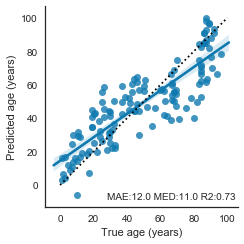

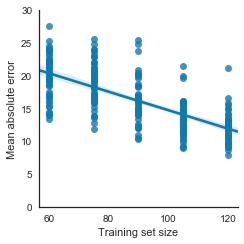

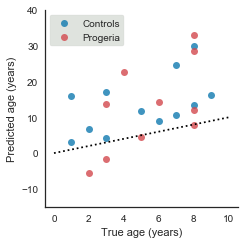

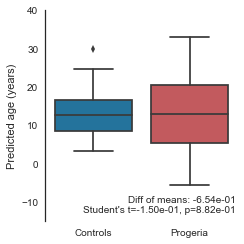

In [271]:

njobs = 20 # set this according to the number of available cores on your machine

search_cval = RepeatedKFold(n_repeats=2, n_splits=10)
lcurve_cval = RepeatedKFold(n_repeats=5, n_splits=10) 

subelast = False # subset_genes_ElasticNet()
parameters = { 'l1_ratio':np.arange(0.,1.1,0.1), 'alpha':np.arange(0.1,1.1,0.1), 'subset_min':[5], 'subset_fold':[5], 'subset_logT':[True]}

elastregr = make_figs( 'Elastic net', model=subelast, 
                  #search_cval=search_cval, parameters=parameters, # uncomment these lines
                  #plot_cval=LeaveOneOut(),                        # to rerun the analysis from scratch 
                  #lcurve_cval=lcurve_cval,                        # instead of loading results from disk
                  njobs=njobs)                                      

Using  subset_genes_SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
         gamma='auto', kernel='rbf', max_iter=-1, shrinking=True,
         subset_fold=0, subset_logT=False, subset_min=0, tol=0.001,
         verbose=False)
LOOCV  Support vector regression MAE:11.9 MED:10.2 R2:0.72


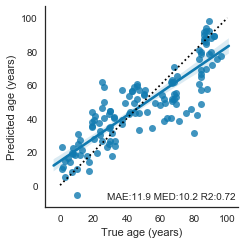

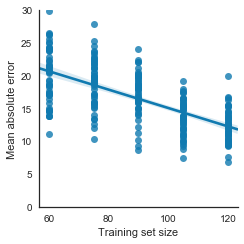

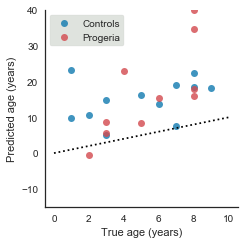

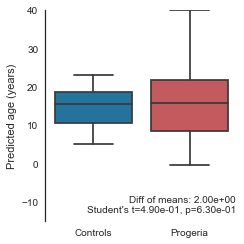

In [272]:

njobs = 20 # set this according to the number of available cores on your machine

search_cval = RepeatedKFold(n_repeats=2, n_splits=10)
lcurve_cval = RepeatedKFold(n_repeats=5, n_splits=10) 

subsvr = subset_genes_SVR()
parameters = { 'kernel':['poly'], 'epsilon':[0.05, 0.1, 0.5, 1.0, 2.0], 'subset_min':[5], 'subset_fold':[5], 'subset_logT':[True], 'C':[1, 5, 10, 50, 100, 500, 1000, 5000],  'degree':[2,3], 'gamma':[1.0/10000, 1.0/5000, 1.0/1000, 1.0/500, 1.0/100, 1.0/50]}

svregr = make_figs( 'Support vector regression', model=subsvr, 
                  #search_cval=search_cval, parameters=parameters, # uncomment these lines
                  #plot_cval=LeaveOneOut(),                        # to rerun the analysis from scratch 
                  #lcurve_cval=lcurve_cval,                        # instead of loading results from disk
                  njobs=njobs)          

Using  subset_genes_LinRegr(convfpkmToTpm=False, copy_X=True, fit_intercept=True,
           n_jobs=1, normalize=False, subset_fold=5, subset_logT=True,
           subset_min=5, verbose=False)
LOOCV  Linear regression MAE:12.1 MED:10.0 R2:0.73


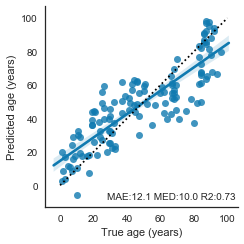

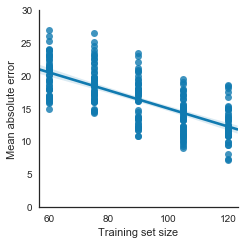

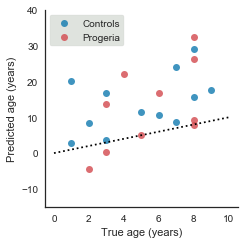

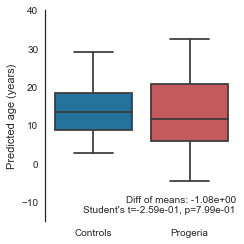

In [273]:

njobs = 20 # set this according to the number of available cores on your machine

search_cval = RepeatedKFold(n_repeats=2, n_splits=10)
lcurve_cval = RepeatedKFold(n_repeats=5, n_splits=10) 

sublin = subset_genes_LinRegr(subset_fold=5,subset_min=5,subset_logT=True)

linregr = make_figs( 'Linear regression', model=sublin, 
                  # no gridsearch since linear regr has no parameters! # uncomment these lines
                  #plot_cval=LeaveOneOut(),                        # to rerun the analysis from scratch 
                  #lcurve_cval=lcurve_cval,                        # instead of loading results from disk
                  njobs=njobs)          

Using  subset_genes_ensemble(class_size=20,
           clf=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='eigen', store_covariance=False, tol=0.0001),
           subset_fold=5, subset_logT=True, subset_min=5, verbose=False)
LOOCV  Ensemble LDA MAE:7.7 MED:4.0 R2:0.81


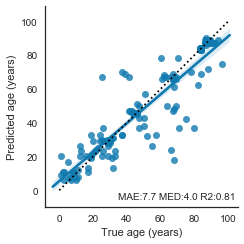

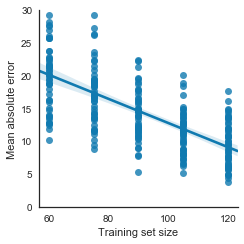

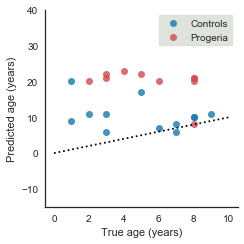

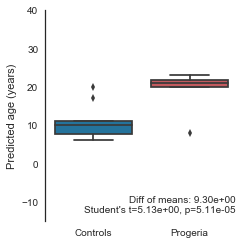

In [275]:
# this will take a really really long time to run... 
# like on the order of a week or several weeks, depending on your computer!
# The eigen solver for LDA uses scipy to calculate eigenmatrices 
# to get the the ratio of between class scatter to within class scatter 
# ... and this is slow because these are huge matrices!
# By slow I mean on the order of a minute per eigen solution, but when multiplied
# by the large number of validation folds and members of the ensemble... its a long time.
# Running this on a machine with 64 2.3Ghz CPUs (E5 Xeon) & 256GB RAM
# where on average it was able to utilize ~40% of the CPU cycles available
# resulted in a run that lasted 4 days, 18 hours

# sklearn/scipy uses LAPACK to do the linear algebra 
# and LAPACK has its own multithreading inside it 
# therefore it is counter-productive to start more than one job at the level of sklearn
njobs = 1 

search_cval = RepeatedKFold(n_repeats=2, n_splits=10)
lcurve_cval = RepeatedKFold(n_repeats=5, n_splits=10) 

clf = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen')
ensemble = subset_genes_ensemble(clf=clf, class_size=20, subset_fold=5,subset_min=5,subset_logT=True)
parameters = {'class_size':[30, 20, 10], 'subset_min':[5], 'subset_fold':[5], 'subset_logT':[True] }

#print "started at {}".format(datetime.now())
ensembleLDA = make_figs( 'Ensemble LDA', model=ensemble, 
#                  search_cval=search_cval, parameters=parameters, # uncomment these lines
#                  plot_cval=LeaveOneOut(),                        # to rerun the analysis from scratch 
#                  lcurve_cval=lcurve_cval,                        # instead of loading results from disk
                  njobs=njobs)

#print "finished at {}".format(datetime.now())

In [235]:
lc = pd.read_csv('lcurve_Ensemble LDA.csv')
lc

Unnamed: 0  Test set mean_absolute_error  \
0             0                     26.071429   
1             1                     27.500000   
2             2                     22.785714   
3             3                     16.000000   
4             4                     25.769231   
5             5                     19.923077   
6             6                     19.384615   
7             7                     17.230769   
8             8                     10.153846   
9             9                     29.153846   
10           10                     22.642857   
11           11                     14.714286   
12           12                     13.714286   
13           13                     27.769231   
14           14                     21.538462   
15           15                     15.000000   
16           16                     26.923077   
17           17                     20.153846   
18           18                     18.923077   
19           19                     20.846154   
20           20                     12.785714   
21           21                     28.214286   
22           22                     20.285714   
23           23                     21.230769   
24           24                     20.615385   
25           25                     22.538462   
26           26                     13.384615   
27           27                     18.769231   
28           28                     25.692308   
29           29                     17.923077   
..          ...                           ...   
220         220                      9.571429   
221         221                     11.642857   
222         222                      9.285714   
223         223                      5.692308   
224         224                     10.000000   
225         225                     11.461538   
226         226                     16.076923   
227         227                      4.846154   
228         228                      7.538462   
229         229                      6.538462   
230         230                      4.357143   
231         231                      7.071429   
232         232                      5.857143   
233         233                      6.230769   
234         234                     14.923077   
235         235                     13.538462   
236         236                     13.923077   
237         237                     10.923077   
238         238                     10.000000   
239         239                     12.076923   
240         240                     12.071429   
241         241                     14.714286   
242         242                     10.785714   
243         243                      7.769231   
244         244                      8.692308   
245         245                      8.384615   
246         246                      3.769231   
247         247                      7.384615   
248         248                      8.769231   
249         249                      8.230769   

     Training set mean_absolute_error  Training set size  Mean absolute error  
0                                 0.0                 60            26.071429  
1                                 0.0                 60            27.500000  
2                                 0.0                 60            22.785714  
3                                 0.0                 60            16.000000  
4                                 0.0                 60            25.769231  
5                                 0.0                 60            19.923077  
6                                 0.0                 60            19.384615  
7                                 0.0                 60            17.230769  
8                                 0.0                 60            10.153846  
9                                 0.0                 60            29.153846  
10                                0.0                 60            22.642857  
11    

In [236]:
from scipy.stats import linregress
x=lc['Training set size']
y=lc['Mean absolute error']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

In [237]:
slope, intercept, r_value, p_value, std_err, r_value**2

(-0.18657343295740217,
 31.352294279574714,
 -0.6646014773840927,
 3.101718402348752e-33,
 0.013319820442234183,
 0.4416951237411187)

In [240]:
from scipy.stats import theilslopes
res = stats.theilslopes(y, x, 0.95)
res

(-0.1794871794871795,
 29.818681318681318,
 -0.20689655172413793,
 -0.15384615384615366)

In [257]:
(5 - 7.7 )/ (-.15) # truncate 95% ci lower bound to 2 significant figures

18.000000000000004

In [258]:
(3 - 7.7 )/ (-.15)

31.333333333333336